In [ ]:
#!git clone https://github.com/alvenchen/nsfw-pytorch.git
#!unzip nsfw-pytorch.zip

In [ ]:
#!pip install mxnet

In [ ]:
#!python  nsfw_pytorch/src/test_img.py --batch_size 1 --image_size 299 --test_data_dir nsfw-pytorch/data/test/ --saved_model nsfw-pytorch/models/resnet50-19c8e357.pth --save_path nsfw-pytorch/data/result/

In [ ]:
#!cp nsfw_pytorch/src/model/resnet.py .
#!cp nsfw_pytorch/src/model/utils.py .

In [ ]:
#model = '../../../cyberbullying_purification/samuel_src/src_files/model/resnet.py'


In [133]:
# general imports
import os
import argparse
import time
import numpy as np
import json
import sys
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
#from data_wrapper import DataWrapper
from tensorboardX import SummaryWriter
import tqdm
from PIL import Image
import glob

#import model
# from model import resnet
# from model.dpn import dpn92
# from model.utils import load_filtered_state_dict, SaveBestModel, AverageMeter, accuracy

# torch attack imports
from torchattacks import *
import torchattacks

# torch vision imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.utils
from torchvision import models
from torchvision import transforms
from torchvision.transforms import GaussianBlur
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
# from utils.extract_distributions import extract_distributions as extract_distributions_fn
# from utils2 import imshow, image_folder_custom_label
from itertools import cycle
import itertools
import more_itertools

## 1. Model

In [134]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
cudnn.enabled = True

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.fc = nn.Linear(2048, 2, bias=True)

num_classes = 2

cwd = os.getcwd()
print(cwd)
torch.manual_seed(0)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


/workspace/adv_robustness/cyberbullying_purification/samuel_src


In [135]:
transform_test = transforms.Compose([transforms.Resize(320),
        transforms.RandomCrop(299), transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

good_img_transform = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

checkpoint = torch.load('non_robust_classifiers/ResNet_SH_27.pth')
model.to(device)
model.eval()
model.load_state_dict(checkpoint, strict=False)

<All keys matched successfully>

In [136]:

test_path = 'datasets/self_harm/test'
testset = torchvision.datasets.ImageFolder(test_path, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=True, num_workers=2)

## Create sample adv images

In [160]:
images, labels = next(itertools.islice(testloader, 1, None))
# For Self harm, 1 is self harm class
print(images.min())
print(adv_image.min())

tensor(-2.0837)
tensor(0., device='cuda:0')


In [161]:
torch.manual_seed(0)

#labels = 2

atk = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=100, random_start=True)
#atk = torchattacks.Square(model, eps=16/255, n_queries=500, n_restarts=1, loss='ce')
#atk = torchattacks.AutoAttack(model, eps=8/255, n_classes=2, version='standard')
#atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100, random_start=True)
adv_image = atk(images, labels)

# images_final = invTrans(images)
# adv_image_final = invTrans(adv_image)

In [162]:
print(adv_image.shape)

torch.Size([1, 3, 299, 299])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


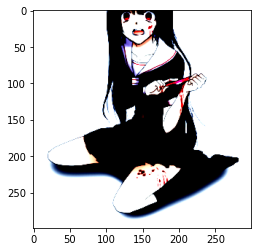

In [163]:
plt.imshow( images.detach().cpu().squeeze().permute(1, 2, 0)  )

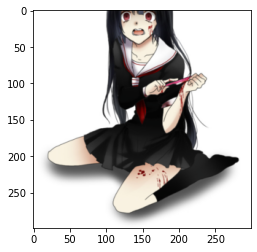

In [45]:
plt.imshow( images_final.detach().cpu().squeeze().permute(1, 2, 0)  )

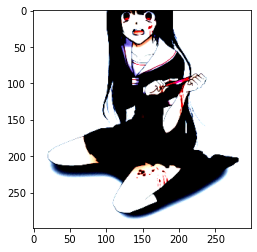

In [46]:
plt.imshow( adv_image.detach().cpu().squeeze().permute(1, 2, 0)  )

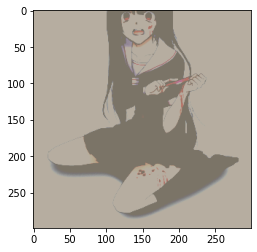

In [47]:
plt.imshow( adv_image_final.detach().cpu().squeeze().permute(1, 2, 0)  )

In [ ]:
torch.manual_seed(0)
for i in range(50):
    images, labels = next(itertools.islice(testloader, i, None))
                          
    label = labels.item()
    outputs = model(images.to(device))
    _, predicted = outputs.max(1)
    pred_val = predicted.item()
    
    total_samples += 1
    if pred_val == label:
        correct += 1

In [139]:
i = 0
for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs, targets
        #print(type(targets.item()))
        adv_image = atk(inputs, targets)
        if targets.item() == 0:
            torch.save(adv_image, 'non_robust_classifiers/self_harm_attacked/non_self_harm'+'/PGD_'+str(i)+'.pt')
            #torchvision.utils.save_image(adv_image, 'non_robust_classifiers/self_harm_attacked/non_self_harm'+'/PGD_'+str(i)+'.png')
            
        if targets.item() == 1:
            torch.save(adv_image, 'non_robust_classifiers/self_harm_attacked/self_harm'+'/PGD_'+str(i)+'.pt')
            #torchvision.utils.save_image(adv_image, 'non_robust_classifiers/self_harm_attacked/self_harm'+'/PGD_'+str(i)+'.png')
            
        #print(targets.item())
        
        i += 1
        if i > 50:
            break

## Test on the attacked images

In [140]:
from src_files.model import resnet
from src_files.model.utils import load_filtered_state_dict, SaveBestModel, AverageMeter, accuracy

In [141]:
model = resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], 2)
checkpoint = torch.load('auxiliary_models/self_harm-pytorch/models/self_harm/epoch_21.pkl')
load_filtered_state_dict(model, checkpoint, ignore_layer=[], reverse=True)
model.to(device)

320 320


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [144]:
test_path = 'non_robust_classifiers/self_harm_attacked'

# transform_test = transforms.Compose([transforms.ToTensor()])

# testset = torchvision.datasets.ImageFolder(test_path, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=1, shuffle=True, num_workers=2)

#transform_test = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.ImageFolder(test_path)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1, shuffle=True, num_workers=2)

FileNotFoundError: Found no valid file for the classes non_self_harm, self_harm. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
correct = 0
total_samples = 0
for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs, targets
        
        label = targets.item()
        outputs = model(inputs.to(device))
        _, predicted = outputs.max(1)
        pred_val = predicted.item()
    
        total_samples += 1
        if pred_val == label:
            correct += 1
        

print(correct / total_samples)

In [172]:
torch.manual_seed(0)
correct = 0
total_samples = 0


atk = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=200, random_start=True)
#atk = torchattacks.Square(model, eps=16/255, n_queries=500, n_restarts=1, loss='ce')
#atk = torchattacks.AutoAttack(model, eps=8/255, n_classes=2, version='standard')
#atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100, random_start=True)
adv_image = atk(images, labels)


for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs, targets
    #print(type(targets.item()))
    adv_image = atk(inputs, targets)
    
    label = labels.item()
        
    outputs = model(adv_image.to(device))
    _, predicted = outputs.max(1)
    pred_val = predicted.item()
    
    total_samples += 1
    if pred_val == label:
        correct += 1
    
    if total_samples > 50:
        break
    
print(correct / total_samples)

0.5294117647058824


In [177]:
torch.manual_seed(1)
correct = 0
total_samples = 0


#atk = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=100, random_start=True)
atk = torchattacks.Square(model, eps=16/255, n_queries=500, n_restarts=1, loss='ce')
#atk = torchattacks.AutoAttack(model, eps=8/255, n_classes=2, version='standard')
#atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100, random_start=True)
adv_image = atk(images, labels)


for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs, targets
    #print(type(targets.item()))
    adv_image = atk(inputs, targets)
    
    label = labels.item()
        
    outputs = model(adv_image.to(device))
    _, predicted = outputs.max(1)
    pred_val = predicted.item()
    
    total_samples += 1
    if pred_val == label:
        correct += 1
    
    if total_samples > 10:
        break
    
print(correct / total_samples)

0.36363636363636365


In [171]:
torch.manual_seed(0)
correct = 0
total_samples = 0


#atk = torchattacks.PGD(model, eps=16/255, alpha=2/255, steps=100, random_start=True)
#atk = torchattacks.Square(model, eps=16/255, n_queries=500, n_restarts=1, loss='ce')
atk = torchattacks.AutoAttack(model, eps=8/255, n_classes=2, version='standard')
#atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100, random_start=True)
adv_image = atk(images, labels)


for batch_idx, (inputs, targets) in enumerate(testloader):
    inputs, targets = inputs, targets
    print(type(targets.item()))
    print(inputs.size())
    adv_image = atk(inputs, targets)
    
    label = labels.item()
        
    outputs = model(adv_image.to(device))
    _, predicted = outputs.max(1)
    pred_val = predicted.item()
    
    total_samples += 1
    if pred_val == label:
        correct += 1
    
    if total_samples > 50:
        break
    
print(correct / total_samples)

<class 'int'>
torch.Size([1, 3, 299, 299])
<class 'int'>
torch.Size([1, 3, 299, 299])
<class 'int'>
torch.Size([1, 3, 299, 299])
<class 'int'>
torch.Size([1, 3, 299, 299])
<class 'int'>
torch.Size([1, 3, 299, 299])


IndexError: index -3 is out of bounds for dimension 1 with size 2

In [62]:
images, labels = next(itertools.islice(testloader, 1, None))
# For Self harm, 1 is self harm class
print(labels)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 232, in __getitem__
    sample = self.transform(sample)
  File "/opt/conda/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 94, in __call__
    for t in self.transforms:
TypeError: 'ToTensor' object is not iterable


In [ ]:
# saved_model = 'self_harm_model/ResNet_SH_7.pth'
# num_classes = 2

# cudnn.enabled = True
# model = resnet.ResNet(torchvision.models.resnet.Bottleneck, [3, 4, 6, 3], num_classes).to(device)
# saved_state_dict = torch.load(saved_model)
# load_filtered_state_dict(model, saved_state_dict, ignore_layer=[], reverse=False)
# model.eval()

In [18]:
def shuffle(datas, labels):
    idx = np.random.permutation(len(datas))
    x = [datas[i] for i in idx]
    y = [labels[i] for i in idx]
    return x,y

def get_dataset(path, disorder=True):
    classes_names = [ name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name)) ]
    classes_names = sorted(classes_names)
    datas = []
    classes = []
    t = int(0)
    for c in classes_names:
        datas += glob.glob(os.path.join(path, c, '*.jpg'))
        datas += glob.glob(os.path.join(path, c, '*.jpeg'))
        datas += glob.glob(os.path.join(path, c, '*.png'))
        classes += [t for i in range(len(datas))]
        t += 1
    if disorder:
        datas, classes = shuffle(datas, classes)
    return datas, classes, classes_names

In [6]:
"""
#%debug
path = path_test
transformations = transforms.Compose([transforms.Resize(320),
                                      transforms.RandomCrop(299), transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
datas, classes, classes_names = get_dataset(path)
dataset = DataWrapper(datas, classes, transformations)
data_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size=1, shuffle=True, num_workers=1)
print(data_loader)
for i, (image, label, name) in enumerate(data_loader):
    print(i, end='')
"""

"\n#%debug\npath = path_test\ntransformations = transforms.Compose([transforms.Resize(320),\n                                      transforms.RandomCrop(299), transforms.ToTensor(),\n                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])\ndatas, classes, classes_names = get_dataset(path)\ndataset = DataWrapper(datas, classes, transformations)\ndata_loader = torch.utils.data.DataLoader(dataset = dataset, batch_size=1, shuffle=True, num_workers=1)\nprint(data_loader)\nfor i, (image, label, name) in enumerate(data_loader):\n    print(i, end='')\n"

In [16]:
#path_test_cb = '../../../../../cyberbullying_purification/cyberbullying_data_splits_clean/test/cyberbullying'
#path_test_ncb = '../../../../../cyberbullying_purification/cyberbullying_data_splits_clean/test/non_cyberbullying'
#path_train_cb = '../../../../../cyberbullying_purification/cyberbullying_data_splits_clean/train/cyberbullying'
#path_train_ncb = '../../../../../cyberbullying_purification/cyberbullying_data_splits_clean/train/non_cyberbullying'

path_test = '/datasets/self_harm/test/'
path_train = '/datasets/self_harm/train/'

In [17]:
#save_path_test_cb = '../../../../data/cyberbullying/attacked/test/cyberbullying/'
#save_path_test_ncb = '../../../../data/cyberbullying/attacked/test/non_cyberbullying/'
#save_path_train_cb = '../../../../data/cyberbullying/attacked/train/cyberbullying/'
#save_path_train_ncb = '../../../../data/cyberbullying/attacked/train/non_cyberbullying/'

save_path_test = '../../../../data/self_harm/attacked/test/'
save_path_train = '../../../../data/self_harm/attacked/train/'

In [18]:
#move to samuel_src/cyberbullying
#%debug
def attack_path(atk_path, save_path, model, cap):    
    transformations = transforms.Compose([transforms.Resize(320),
                                          transforms.RandomCrop(299), transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                   transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ])])
    X, Y, class_names = get_dataset(atk_path)
    dataset = DataWrapper(X, Y, transformations)
    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=1,
                                              shuffle=True,
                                              num_workers=1)
    gb = GaussianBlur(7, sigma = 3)
    # create folder if not existent
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if not os.path.exists(save_path+class_names[0]):
        os.makedirs(save_path+class_names[0])
    if not os.path.exists(save_path+class_names[1]):
        os.makedirs(save_path+class_names[1])
    skipped = []
    

    
    for i, (image, label, name) in enumerate(data_loader):
        save_name = str(i) + '_'
        # get a random attack
        atk_list = ['Clean', 'PGD', 'Square', 'AutoAttack']
        probs = [0.40, 0.20, 0.20, 0.20]
        blur_list = ['gb', 'ngb']
        blur_probs = [0.5, 0.5]
        attack_name = np.random.choice(atk_list, 1, p=probs)[0]
        save_name += attack_name
        # if clean save the image as is
        if attack_name == 'Clean':
            atk = torchattacks.VANILA(model)
        # else
        else:
            # set the attack
            if attack_name == 'PGD':
                atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100, random_start=True)
            elif attack_name == 'Square':
                atk = torchattacks.Square(model, eps=16/255, n_queries=10000, n_restarts=1, loss='ce')
            elif attack_name == 'AutoAttack':
                atk = torchattacks.AutoAttack(model, eps=8/255, n_classes=2, version='standard')
        # launch attack
        if image.shape == (224,224,4):
            image = image[:, :, :3]
        try:
            adv_img = atk(image, label)
            blur_decision = np.random.choice(blur_list, 1, p=blur_probs)
            if blur_decision == 'gb':
                adv_img = gb(adv_img)
                save_name += '_gb'
            adv_img = invTrans(adv_img)
            torchvision.utils.save_image(adv_img, save_path + class_names[int(label[0])] + '/' + save_name + '.png')
        except:
            skipped.append((name, attack_name, i))
            #print('error: {}\n\tattack:{}\t{}'.format(name, attack_name, i))
        if i >= cap:
            break
    return skipped

In [19]:
#%debug
skipped_test = attack_path(path_test, save_path_test, model)
skipped_train = attack_path(path_train, save_path_train, model)

error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/8ca4ca9f34ce4fd9bbacac60fba71393.jpg',)
	attack:AutoAttack	25
error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/8fe5e391f84b4193a2da0f8774fb3562.png',)
	attack:AutoAttack	65
error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/8c15fcecc92b4f1ca9fe0be1c1c03758.jpg',)
	attack:AutoAttack	217
error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/8dcb464b962f49969a28abf153978d31.jpg',)
	attack:AutoAttack	227
error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/9a82e53779e842189be78af2a484e30c.jpg',)
	attack:AutoAttack	255
error: ('../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/8c7a30a6add14bd99b3f28f744169cd3.jpg',)
	attack:AutoAttack	260
error: ('../../../../../

In [20]:
def rename_clean(path):
    for dirpath, dirnames, filenames in os.walk(path):        
        for filename in filenames:
            if "Clean" in filename:
                newname = filename.replace("Clean", "Rotated")
                os.rename(os.path.join(dirpath, filename), os.path.join(dirpath, newname))

                

In [30]:
import random
import shutil
def copy_random_files(src_path, dest_path, num_files):
    c = 0
    for dir_path, dir_names, filenames in os.walk(src_path):
        if dir_path == src_path:
            print(dir_path)
            print(dir_names)
            print(len(filenames))
            to_move = random.sample(filenames, num_files)
            for file in to_move:
                new_name = str(c) + "_Clean.png"
                shutil.copy(os.path.join(dir_path, file), os.path.join(dest_path, new_name))
                c += 1

In [31]:
src_path1 = '../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/self_harm/'
dest_path1 = '../../../../data/self_harm/attacked/test/self_harm/'

src_path2 = '../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/'
dest_path2 = '../../../../data/self_harm/attacked/test/non_self_harm/'

src_path3 = '../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/train/self_harm/'
dest_path3 = '../../../../data/self_harm/attacked/train/self_harm/'

src_path4 = '../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/train/non_self_harm/'
dest_path4 = '../../../../data/self_harm/attacked/train/non_self_harm/'


In [32]:
copy_random_files(src_path1, dest_path1, 100)
copy_random_files(src_path2, dest_path2, 100)
copy_random_files(src_path3, dest_path3, 1000)
copy_random_files(src_path4, dest_path4, 1000)

../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/self_harm/
[]
211
../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/test/non_self_harm/
[]
285
../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/train/self_harm/
[]
1680
../../../../../cyberbullying_purification/samuel_src/datasets/self_harm/train/non_self_harm/
[]
2278


In [ ]:
atks = [
    #FGSM(model, eps=8/255),
    #BIM(model, eps=8/255, alpha=2/255, steps=100),
    #RFGSM(model, eps=8/255, alpha=2/255, steps=100),
    #CW(model, c=1, lr=0.01, steps=100, kappa=0),
    #PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
    #PGDL2(model, eps=1, alpha=0.2, steps=100),
    #EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    #FFGSM(model, eps=8/255, alpha=10/255),
    #TPGD(model, eps=8/255, alpha=2/255, steps=100),
    #MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model),
    #GN(model, std=0.1),
    #APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    #APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    #APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    #FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    #FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model, eps=16/255, n_queries=10000, n_restarts=1, loss='ce'),
    AutoAttack(model, eps=16/255, n_classes=10, version='standard'),
    #OnePixel(model, pixels=5, inf_batch=50),
    #DeepFool(model, steps=100),
    #DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF

print("Adversarial Image & Predicted Label")
save_path = 'data/perturbations/'
input_path  = 'data/clean/'

for atk in atks :
    print("-"*70)
    print(atk)
    
    correct = 0
    total = 0
    
    # save attack name. if path for saving attacked image does not exist, make it
    atk_name = str(atk).split('(')[0]
    atk_path = 'data/attacked/' + atk_name + '64'
    if not os.path.exists(atk_path):
        os.makedirs(atk_path)
    
    # iterate through images
    for i in range(1001, 1051):
        # load the image
        file_path = input_path + str(i) + '.jpg'
        image = Image.open(file_path)
        x = TF.to_tensor(image)
        x.unsqueeze_(0)
        # put image to device
        x = x.to(device)
        if x.shape == (224,224,4):
            image = image[:, :, :3]
        # get correct label for image
        labels[0] = int(torch.topk(model(x), k = 1)[1][0][0])
        # attack the image
        adv_image = atk(x, labels)
        labels = labels.to(device)
        outputs = model(adv_image)
        # isolate perterbation
        perturbation = adv_image - x
        # save perturbation as png
        torchvision.utils.save_image(perturbation, save_path + atk_name + str(i) + 'pert.png')
        # save the attacked image
        torchvision.utils.save_image(adv_image, atk_path + '/' + atk_name + str(i) + '.png')